<a href="https://colab.research.google.com/github/danialzendehdel/Computational_Intelligence-/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Demo 

# Setup

In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import gc
import tensorflow as tf 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential , Model 

from keras.preprocessing import image
from PIL import Image, ImageDraw
import cv2

# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D ,MaxPool2D,Input, Dropout , MaxPooling2D,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization,Activation
from keras import regularizers, optimizers 
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

import matplotlib.pyplot as plt
%matplotlib inline  

## tensorboard
import shutil

try:
  shutil.rmtree('logs')
except:
  pass


from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
path = '/content/gdrive/My Drive/Kaggle'
os.chdir(path)

#Load data

In [5]:
path_to_test_csv_file = '/content/gdrive/My Drive/Kaggle/resized_images/test/ship_test.csv'

test_files = pd.read_csv(path_to_test_csv_file,dtype='str')
test_files

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1153400.jpg,128,128,criuse,6,38,122,104
1,1566197.jpg,128,128,criuse,16,43,66,79
2,1609535.jpg,128,128,criuse,29,39,118,89
3,1893465.jpg,128,128,criuse,6,33,119,111
4,2004193.jpg,128,128,military,6,34,121,78
5,2012365.jpg,128,128,military,6,32,122,89
6,2041039.jpg,128,128,military,4,30,122,104
7,2062572.jpg,128,128,military,11,15,121,100
8,2833420.jpg,128,128,cargo,7,14,120,119
9,2833438.jpg,128,128,cargo,7,13,120,121


In [7]:
## test bbox Normalization 

test_files['xmin'] = test_files['xmin'].apply(lambda x : int(x)/128)
test_files['ymin'] = test_files['ymin'].apply(lambda x : int(x)/128)
test_files['xmax'] = test_files['xmax'].apply(lambda x : int(x)/128)
test_files['ymax'] = test_files['ymax'].apply(lambda x : int(x)/128)
test_files['class'][test_files['class'] == 'criuse'] = 'cruise'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
dic = dict(test_files['class'].value_counts())
fig = go.Figure(
    data=[go.Bar(x=list(dic.keys()),y =list(test_files['class'].value_counts()))],
    layout=go.Layout(
        title=go.layout.Title(text="Quantity of each class")
    )
)

fig.show()

In [9]:
def imageLoader(path,img_list) : 

  data_img = []
  # img_list = list(train_files['filename'])
  for each in img_list:
    # Each image path
    each_path = os.path.join(path, each)
    # Read each imagee
    each_img = (cv2.imread(each_path))
    # OpenCv default color is BGR. Convert it to RGB
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    # Resize the images
    each_img_resized = cv2.resize(each_img, (224,224))

    # image = each_img_resized.astype('float32')
    # each_img_resized /= 255
    # Save arrays to a list
    data_img.append(each_img_resized)

  return data_img


In [11]:
# List of image names
column = ['xmin' , 'ymin' , 'xmax' ,'ymax']
test_list = list(test_files['filename'])
path_test = '/content/gdrive/My Drive/Kaggle/resized_images/test/image/'

test_data = imageLoader(path_test,test_list)
# Converting list to numpy array
TEST_images = np.array(test_data)
print('Shape of test data: ', TEST_images.shape)


TEST_bbox = test_files[column].to_numpy()
TEST_labels = test_files['class']

Shape of test data:  (20, 224, 224, 3)


In [13]:
## create a dictionary in order to assign each of 5 labels to a number 
target_dict={k: v for v, k in enumerate(np.unique(TEST_labels))}
print(target_dict)
TEST_labels_n = [target_dict[TEST_labels[i]] for i in range(len(TEST_labels))]

{'cargo': 0, 'carrier': 1, 'cruise': 2, 'military': 3, 'tanker': 4}


#Functions 

In [14]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
def result_visual(history) : 
  
  fig = make_subplots(rows=3, cols=1,
                      subplot_titles=("Total Loss","Class Loss", "BBOX Loss"),
                      vertical_spacing=0.2)

  # subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4","Plot 4")

  fig.add_trace(go.Scattergl(
                      y=history.history['loss'],
                      name='Train'),row=1, col=1)
  fig.add_trace(go.Scattergl(
                      y=history.history['val_loss'],
                      name='Valid'),row=1, col=1)

  fig.add_trace(go.Scattergl(
                      y=history.history['class_out_loss'],
                      name='Train'),row=2, col=1)
  fig.add_trace(go.Scattergl(
                      y=history.history['val_class_out_loss'],
                      name='Valid'),row=2, col=1)

  fig.add_trace(go.Scattergl(
                      y=history.history['box_out_loss'],
                      name='Train'),row=3, col=1)
  fig.add_trace(go.Scattergl(
                      y=history.history['val_box_out_loss'],
                      name='Valid'),row=3, col=1)


  fig.update_layout(height=800, width=700,
                    title_text="LOSS",
                    xaxis_title='Epoch',
                    yaxis_title='LOSS')
  # Update xaxis properties
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  fig.update_xaxes(title_text="Epoch", row=2, col=1)
  fig.update_xaxes(title_text="Epoch", showgrid=True, row=3, col=1)


  # Update yaxis properties
  fig.update_yaxes(title_text="LOSS", row=1, col=1)
  fig.update_yaxes(title_text="LOSS",  row=2, col=1)
  fig.update_yaxes(title_text="LOSS", showgrid=True, row=3, col=1)



  fig.show()

  fig2 = go.Figure()
  fig2.add_trace(go.Scattergl(
                      y=history.history['box_out_mae'],
                      name='Train'))
  fig2.add_trace(go.Scattergl(
                      y=history.history['val_box_out_mae'],
                      name='Valid'))
  fig2.update_layout(height=500, 
                    width=700,
                    title='Mean Absolute Error for age feature',
                    xaxis_title='Epoch',
                    yaxis_title='Mean Absolute Error')
  fig2.show()

  fig3 = go.Figure()
  fig3.add_trace(go.Scattergl(
                      y=history.history['class_out_accuracy'],
                      name='Train'))
  fig3.add_trace(go.Scattergl(
                      y=history.history['val_class_out_accuracy'],
                      name='Valid')
                      )
  fig3.update_layout(height=500, width=700,
                    title_text="ACCURACY",
                    xaxis_title='Epoch',
                    yaxis_title='Accuracy')



  fig3.show()

In [15]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box,4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [16]:
def prediction_vis(images,gt_bbox,predict_bbox,gt_label,predict_labels,iou=None): 

  # Matplotlib config
  plt.rc('image', cmap='gray')
  plt.rc('grid', linewidth=0)
  plt.rc('xtick', top=False, bottom=False, labelsize='large')
  plt.rc('ytick', left=False, right=False, labelsize='large')
  plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
  plt.rc('text', color='a8151a')
  plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts

  
  counter=0
  plt.figure(figsize=(10, 15))
  x = len(images)
  
  for i in range(9) : 
    counter += 1
    height , width,channel = 224,224,3
    ax = plt.subplot(3,3,i+1)
    xmin , ymin , xmax , ymax = list(gt_bbox[i])
    xminp, yminp, xmaxp, ymaxp = list(predict_bbox[i])
    image = Image.fromarray((images[i]).astype(np.uint8))
    draw = ImageDraw.Draw(image)
    draw.rectangle((int(xmin*width),int(ymin*height),int(xmax*width),int(ymax*height)),outline='green',width=3)
    draw.rectangle((int(xminp*width),int(yminp*height),int(xmaxp*width),int(ymaxp*height)),outline='red',width=3)
    plt.imshow(image)
    # if gt_label : 
    #   plt.text(int(xmin*width),
    #            int(ymin*height),
    #            target_dict2[np.argmax(gt_label[i])],
    #            backgroundcolor = 'green',
    #            horizontalalignment='right',
    #            c='black',
    #            size='large')
     
      
    plt.text(int(xmin*width),
             int(ymin*height),
             target_dict2[(gt_label[i])],
             backgroundcolor = 'green',
             horizontalalignment='right',
             c='black',
             size='large')
    plt.title('IOU : ' + str(format((iou[i][0]*100),'.2f')),size='x-large')
   
    # if predict_labels : 
    plt.text(int(xminp*width),int(yminp*height),
              target_dict2[np.argmax(predict_labels[i])],
              backgroundcolor = 'red',
              horizontalalignment='left',
              c='black',
              size='x-large')
    plt.axis("off")



In [17]:
def result_images(images,gt_bbox,gt_label,model_test=None ,model_classification = None,model_reg= None) : 
  #Makes predictions
  if model_test : 
    predicted_labels,predicted_bboxes = model_test.predict(images, batch_size=16)
  else : 
    predicted_labels = model_classification.predict(images)
    predicted_bboxes = model_reg.predict(images)

    # print(predicted_labels)
    # predicted_labels = np.argmax(predicted_labels)
  #Calculates IOU and reports true positives and false positives based on IOU threshold
  iou = intersection_over_union(predicted_bboxes, gt_bbox)
  iou_threshold = 0.5
  # print(iou)

  # print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
  # print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

  prediction_vis(images=images,
               gt_bbox=(gt_bbox),
               predict_bbox=(predicted_bboxes),
               gt_label=gt_label,
               predict_labels=predicted_labels,
               iou=iou)

# Models 

In [18]:
def get_multi_model() :
  mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
  # pass the inputs into this modle object to get a feature extractor for these inputs
  inputs = tf.keras.Input(shape=(224,224,3),name='image')
  feature_extractor = mobilenet_model(inputs)
  x2 = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor)  
      
      # flatten layer
  x = tf.keras.layers.Flatten()(x2)
      
      # 1024 Dense layer, with relu
  x = tf.keras.layers.Dense(1024,activation='relu')(x)
      
      # 512 Dense layer, with relu
  x1 = tf.keras.layers.Dense(512,activation='relu')(x)

      ## khodam ezafe kardam,###############################
  y_l = tf.keras.layers.Dropout(0.3)(x)
  y_l = tf.keras.layers.Dense(256,activation='relu')(x1)


  y_b = tf.keras.layers.Dense(512,activation='relu')(x1)
  y_b = tf.keras.layers.Dense(512,activation='relu')(y_b)
  y_b = tf.keras.layers.Dropout(0.3)(y_b)
  y_b = tf.keras.layers.Dense(256,activation='relu')(y_b)
  y_b = tf.keras.layers.Dropout(0.3)(y_b) 
  y_b = tf.keras.layers.Dense(256,activation='relu')(y_b)   

  bounding_box_regression_output =tf.keras.layers.Dense(4,activation='relu',name='box_out')(y_l) 
  label_output = tf.keras.layers.Dense(5,activation='softmax',name='class_out')(x2)

  model = tf.keras.Model(inputs=inputs, outputs=[label_output,bounding_box_regression_output])

  return model

In [24]:
from tensorflow.keras.applications.xception import Xception
def get_Class_Model() : 

  # Defining the pretrained base model
  base = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
  x = base.output
  x = GlobalAveragePooling2D()(x)
  # Defining the head of the model where the prediction is conducted
  head = Dense(5, activation='softmax')(x)
  # Combining base and head 
  model = Model(inputs=base.input, outputs=head)
  # Compiling the model
  model.compile(optimizer=Adam(lr=0.0001), 
                loss = 'categorical_crossentropy', 
                metrics=['accuracy'])
  
  return model

In [25]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

def get_Reg_model() : 

  inputs = tf.keras.Input(shape=(224,224,3),name='image')
  mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
  feature_extractor = mobilenet_model(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024,activation='relu')(x)
  x = tf.keras.layers.Dense(512,activation='relu')(x)
  
  bounding_box_regression_output =tf.keras.layers.Dense(4,activation='relu')(x)
  model = tf.keras.Model(inputs=inputs, outputs=bounding_box_regression_output)

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9), loss="mse", metrics=["mae",'accuracy'])
  return model

# Predictions

## Multiple output Model

In [19]:
multi_model = get_multi_model()
multi_model.load_weights('/content/gdrive/My Drive/Kaggle/resized_images/Multi_weights')

9412608/9406464 [==============================] - 0s 0us/step


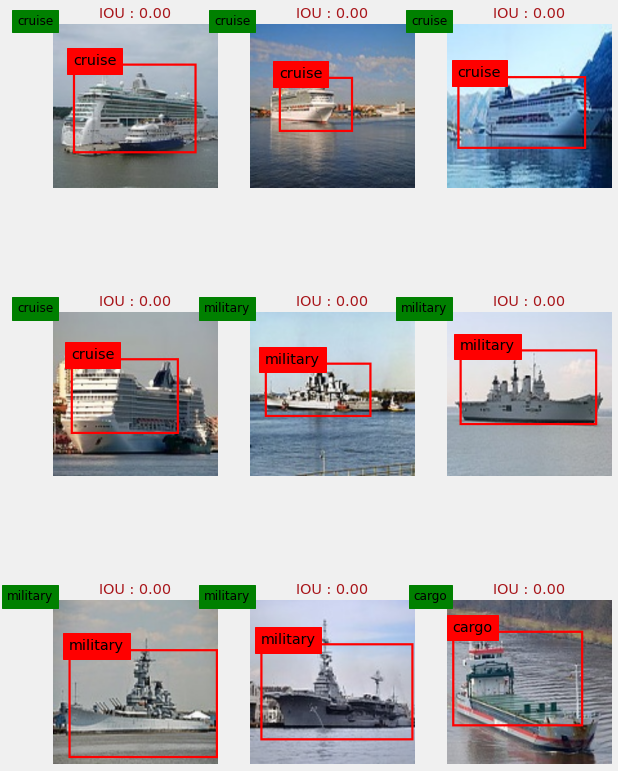

In [23]:
## another dictionary for visualization of data (for np.argmax)
target_dict2 = {0 : 'cargo', 1 : 'carrier', 2 : 'cruise', 3 : 'military', 4 : 'tanker'}
result_images(images = TEST_images,
              gt_bbox=TEST_bbox,
              gt_label = TEST_labels_n,
              model_test=multi_model,
              model_classification = None,
              model_reg= None)

## Second Model

In [26]:
## regressiom model
path_reg = '/content/gdrive/My Drive/Kaggle/resized_images/Regression_weights2'
model_reg2 = get_Reg_model()
model_reg2.load_weights(path_reg)

## classification model
model_classification = get_Class_Model()
model_classification.load_weights('/content/gdrive/My Drive/Kaggle/resized_images/classification_weights2')

83689472/83683744 [==============================] - 1s 0us/step


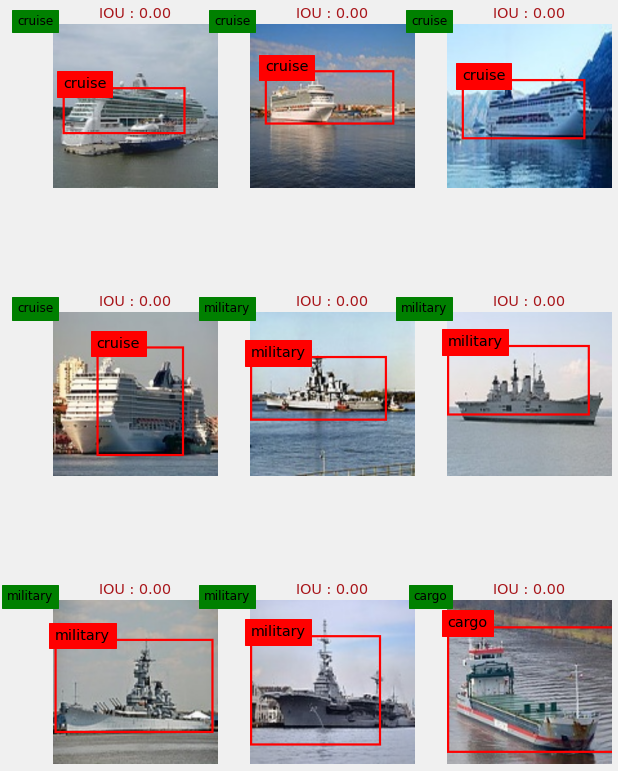

In [27]:
result_images(images=TEST_images,
              gt_bbox = TEST_bbox,
              gt_label = TEST_labels_n,
              model_classification=model_classification,
              model_test = None,
              model_reg = model_reg2)